 ### ガウス過程
 
 これまで見てきた全てのモデルはパラメトリックモデルでした。ノンパラメトリックモデル(Non-parameteric)とはパラメータの数がデータとともに増加するモデルのことを言います。言い換えると、ノンパラメトリックモデルは潜在的に無限のパラメータを持ったモデルです。
 
 正規分布の式を無限次元に拡張する方法と、**関数の分布(distribution over function)**を学ぶ方法を調べることで、カーネルの例を見ていきましょう。
 
 
 #### カーネルベースモデル
 カーネルは、比較的簡単に計算でき、柔軟な非線型モデルの基礎として使えるからです。カーネルはいくらか異なる数学的な特性を持っています。ベイジアンの議論の目的からすると、基本的には、カーネルは二つの入力から常に正の値を一つ出力する対称関数と言えるでしょう。この見方をすると、二つの入力間の類似度を表すものとして、カーネル関数の出力を解釈することができます。
 
 いくつかの有益なカーネルが存在します。画像認識や文書解析といった個別の問題に特化しているものもあれば、周期関数をモデリングするに適したものもあります。
 

In [24]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az


RANDOM_SEED = 58
plt.style.use(['arviz-darkgrid'])
np.set_printoptions(precision=2)

Text(0, 0.5, '$y$')

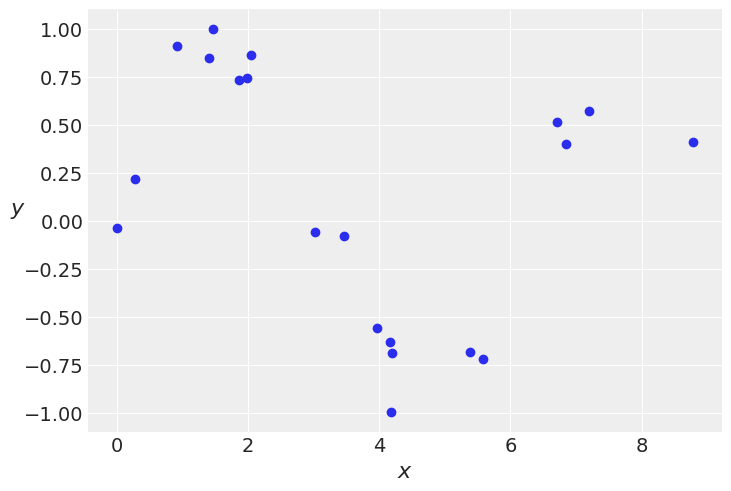

In [2]:
np.random.seed(1)
x = np.random.uniform(0, 10, size=20)
y = np.random.normal(np.sin(x), 0.2)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$',fontsize=16, rotation=0)

In [3]:
def gauss_kernel(x, n_knots):
    knots = np.linspace(x.min(), x.max(), n_knots)
    w = 2
    return np.array([np.exp(-(x-k)**2/w) for k in knots])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, gamma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
/home/hona/anaconda3/envs/py38/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'gamma\n0'}>,
        <AxesSubplot:title={'center':'gamma\n0'}>],
       [<AxesSubplot:title={'center':'gamma\n1'}>,
        <AxesSubplot:title={'center':'gamma\n1'}>],
       [<AxesSubplot:title={'center':'gamma\n2'}>,
        <AxesSubplot:title={'center':'gamma\n2'}>],
       [<AxesSubplot:title={'center':'gamma\n3'}>,
        <AxesSubplot:title={'center':'gamma\n3'}>],
       [<AxesSubplot:title={'center':'gamma\n4'}>,
        <AxesSubplot:title={'center':'gamma\n4'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

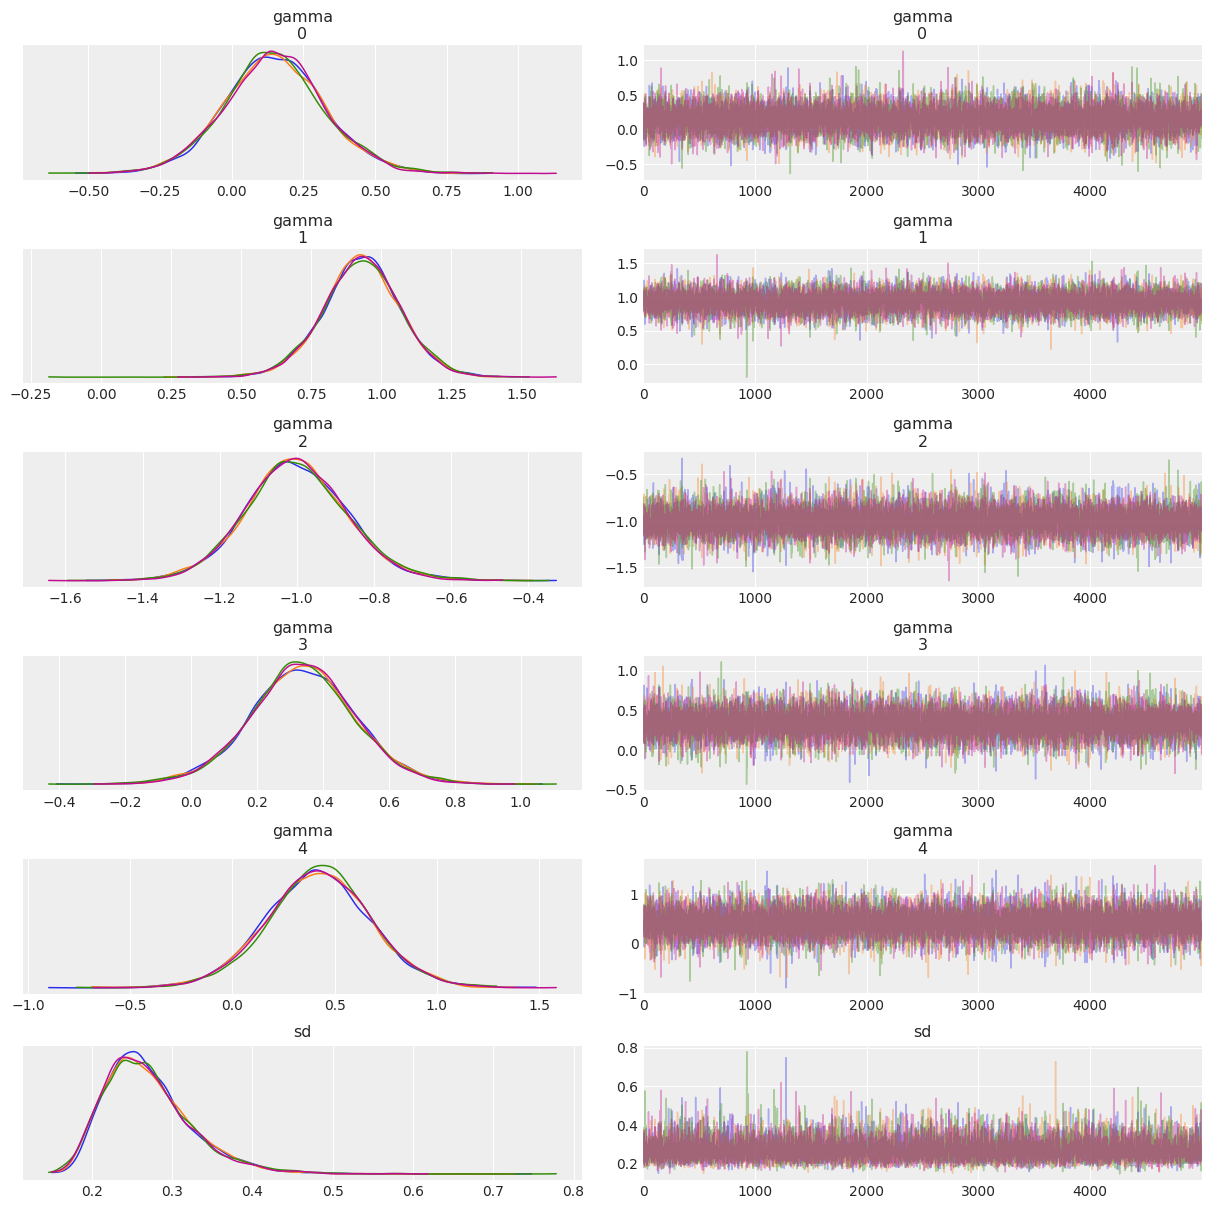

In [25]:
n_knots = 5

with pm.Model() as kernel_model:
    gamma= pm.Cauchy('gamma', alpha=0, beta=1, shape=n_knots)
    sd = pm.Uniform('sd', 0, 10)
    mu = pm.math.dot(gamma, gauss_kernel(x, n_knots))
    y1 = pm.Normal('y1', mu=mu, sd=sd, observed=y)
    
    kernel_trace = pm.sample(5000)

az.plot_trace(kernel_trace)

/home/hona/anaconda3/envs/py38/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Text(0, 0.5, '$f(x)$')

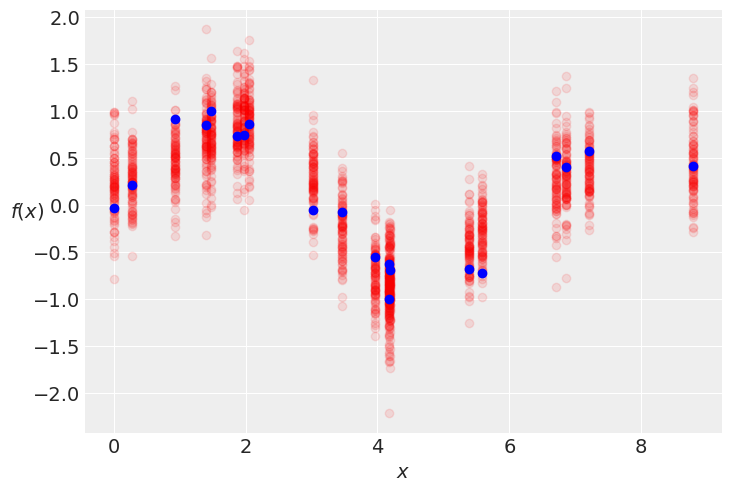

In [21]:
# 事後予測チェック
ppc = pm.sample_posterior_predictive(kernel_trace, model=kernel_model, random_seed=RANDOM_SEED, samples=100)
plt.plot(x, ppc['y1'].T, 'ro', alpha=0.1)

plt.plot(x, y, 'bo')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$f(x)$', fontsize=14, rotation=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, gamma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.
/home/hona/anaconda3/envs/py38/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


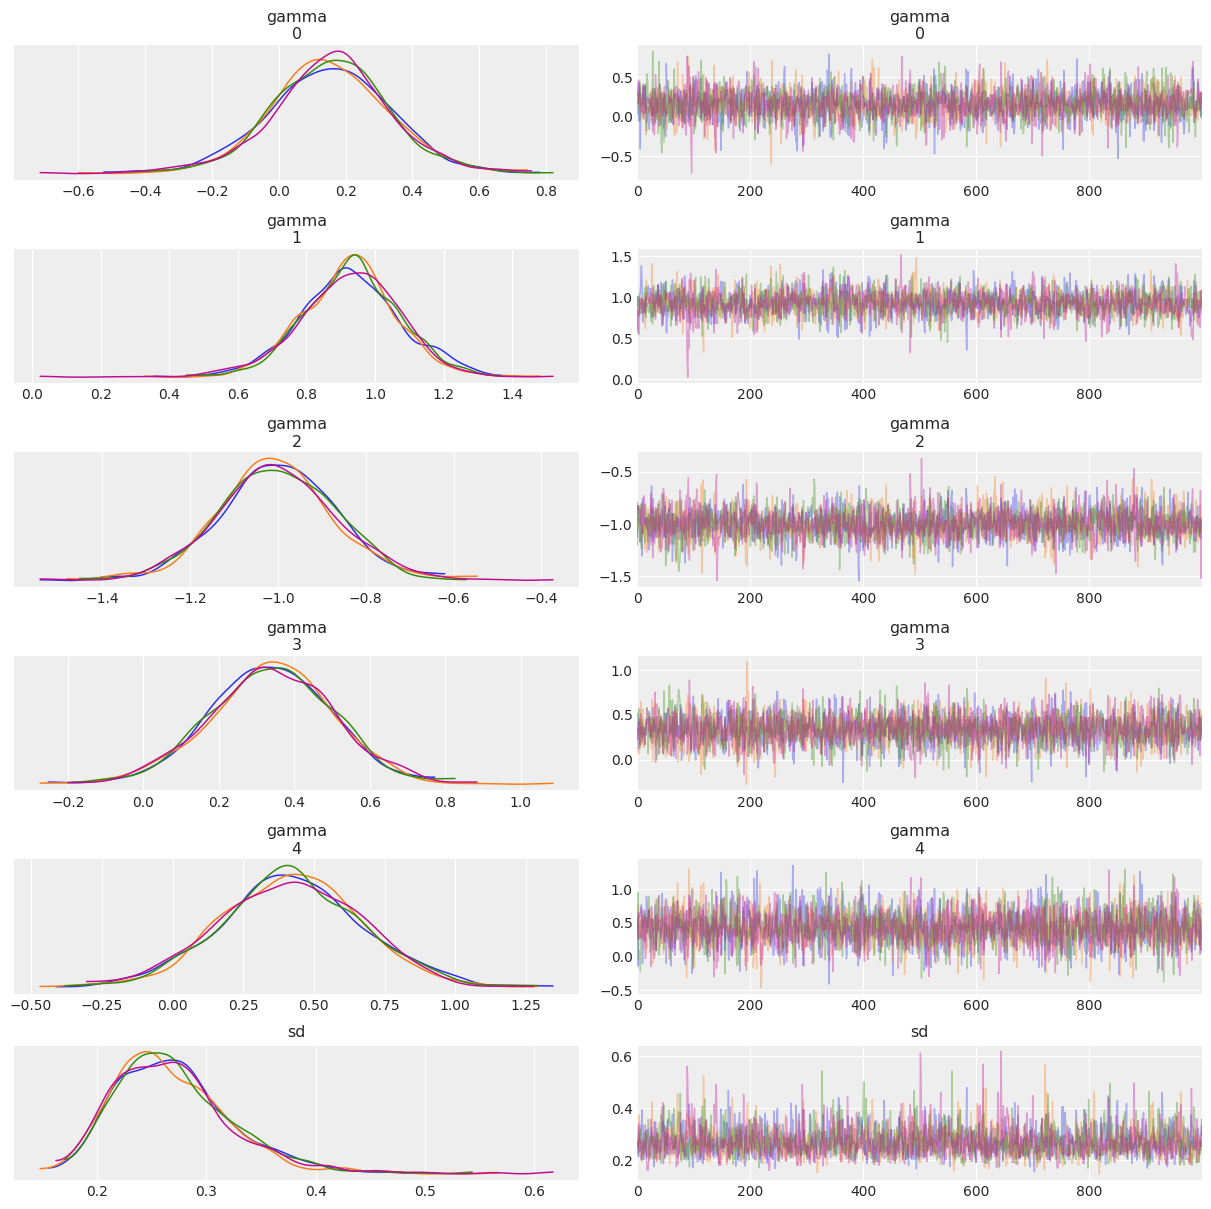

In [26]:
with kernel_model:
    trace_1 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)
az.plot_trace(trace_1);

In [23]:
with kernel_model:
    ppc = pm.sample_posterior_predictive(
        trace_1, var_names=['y1'], random_seed=RANDOM_SEED
    )

/Users/narenbao/anaconda3/envs/op/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:xlabel='y1'>

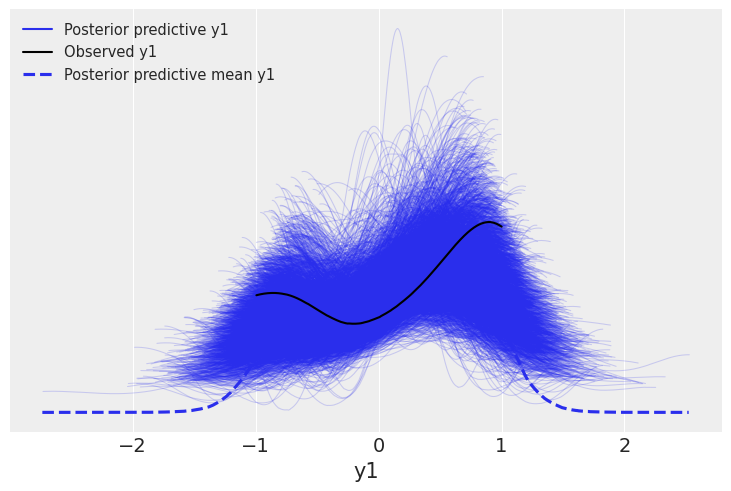

In [24]:
idata = az.from_pymc3(trace_1, posterior_predictive=ppc)
az.plot_ppc(idata)

Text(0, 0.5, '$f(x)$')

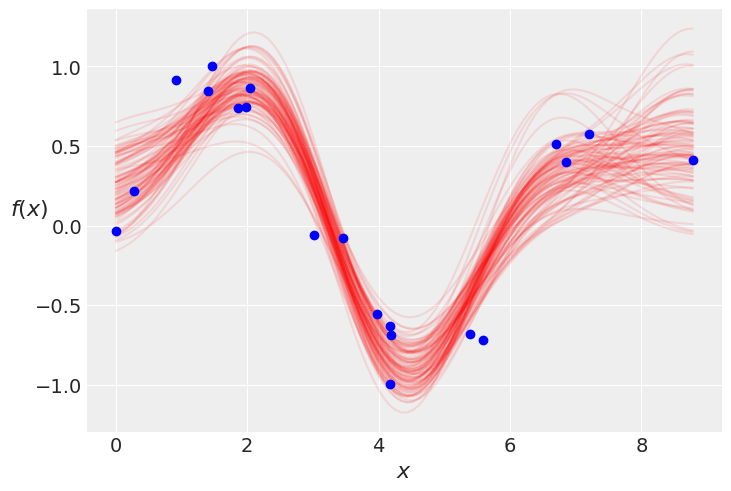

In [28]:
new_x =np.linspace(x.min(), x.max(), 100)
k = gauss_kernel(new_x, n_knots)
gamma_pred = kernel_trace['gamma']
for i in range(100):
    idx = np.random.randint(0, len(gamma_pred))
    y_pred = np.dot(gamma_pred[idx], k)
    plt.plot(new_x, y_pred, 'r-', alpha=0.1)

plt.plot(x, y, 'bo')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

### ガウス過程

ガウス過程を導入する前に関数とは何なのかを考えてみましょう。ここでは、関数を一組の入力から一組の出力への写像とみなします。ベイジアン観点からの線形回帰は、線形関数に正規分布を従う乱数を付加することでベイズ的な手法を使えてきました。その乱数を事前分布を与えることで不確実性を制御してきました。データに対して、線形関数以外にどの関数を使えばよいかをわからない時には**多変量正規分布(multivariate gaussian)**を事前分布すると、幅広く関数を記述することができます。

すべての$x_i$の値にたいして、未知なる平均と未知なる標準偏差を持った正規分布に従うが$y_i$あるとします。**平均関数(mean function)**と**共分散関数(covariation function)**によってパラメータされます。GPは無限に多い確率変数に同時分布です。共分散関数にカーネルを使います。

事前分布から何なのかという直感を得るために、そこからサンプルをとってみましょう。

In [29]:
squared_distance = lambda x,y: np.array([[(x[i] -y[j])**2 for i in range(len(x))] for j in range(len(y))])
print(squared_distance)

<function <lambda> at 0x7fc6db6d8790>


Text(0, 0.5, '$f(x)$')

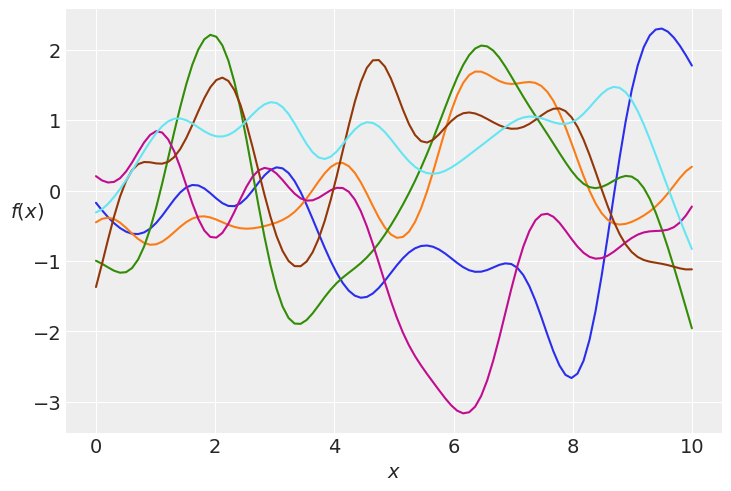

In [36]:
np.random.seed(1)
test_points = np.linspace(0, 10, 100)
cov = np.exp(-squared_distance(test_points, test_points))
plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=6).T)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$f(x)$', fontsize=14, rotation=0)

上の図からわかるように、GPの事前分布をつかうことでは様々な滑らかの分布を生成することができます。
つぎはガウスカーネルをハイパーパラメータ拡張して、生成してみましょう。

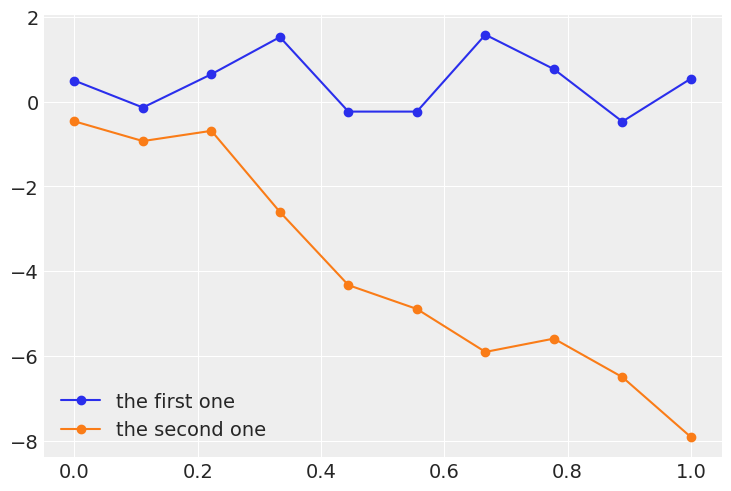

In [37]:
np.random.seed(42)
x = np.linspace(0, 1, 10)

y = np.random.normal(0, 1, len(x))
plt.plot(x, y, 'o-', label='the first one')

y = np.zeros_like(x)
for i in range(len(x)):
    y[i] = np.random.normal(y[i-1], 1)
plt.plot(x, y, 'o-', label='the second one')

plt.legend()

In [38]:
#Covariance functions and kernels
def exp_quad_kernel(x, knots, ℓ=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*ℓ**2)) for k in knots])

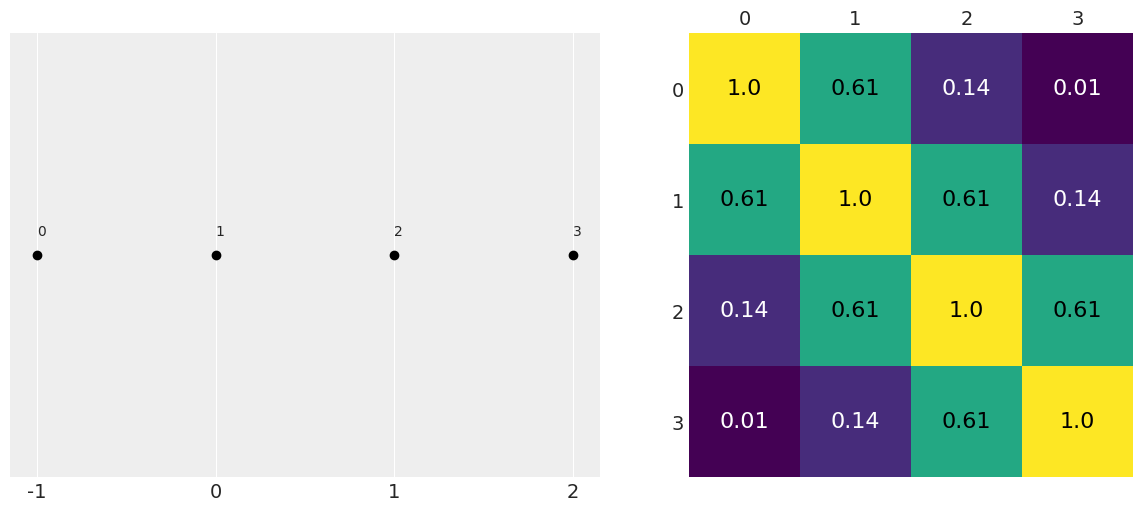

In [39]:
data = np.array([-1, 0, 1, 2])  # np.random.normal(size=4)
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))
#ax[0].set_xticklabels(np.round(data, 2), rotation=70)

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                   color=colors[int(im.norm(cov[i, j]) > 0.5)],
                   ha='center', va='center', fontdict={'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

Text(-0.03, 0.5, 'f(x)')

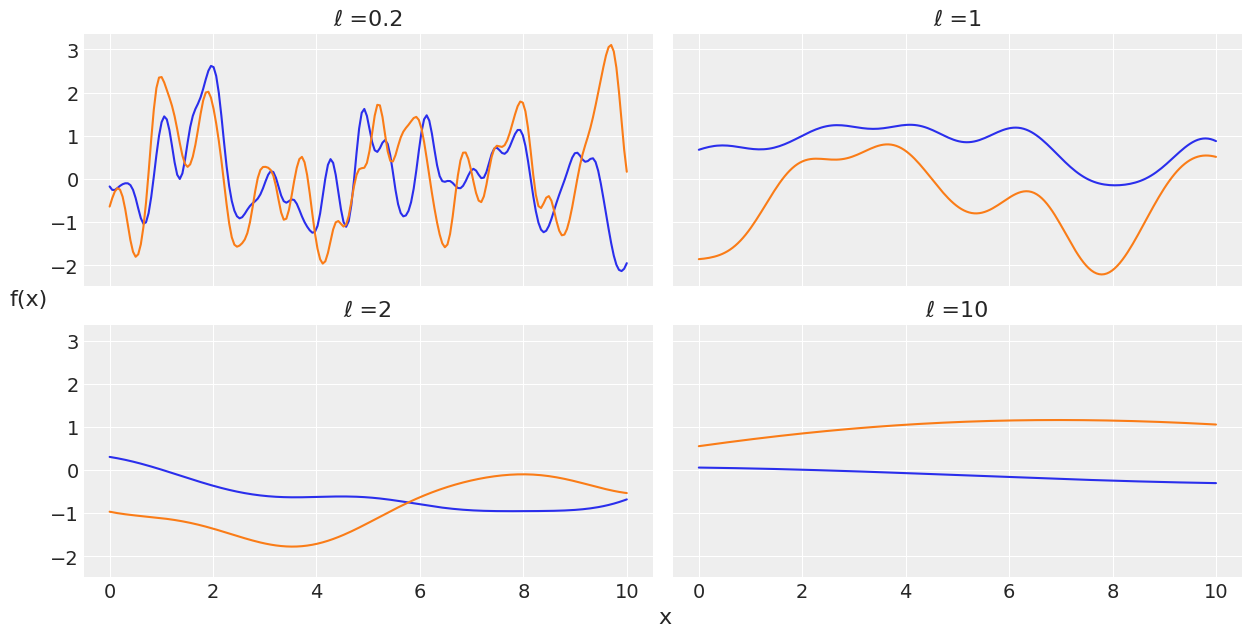

In [42]:
np.random.seed(42)

test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True,
                       sharey=True, constrained_layout=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=2).T)
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)

Text(0, 0.5, 'f(x)')

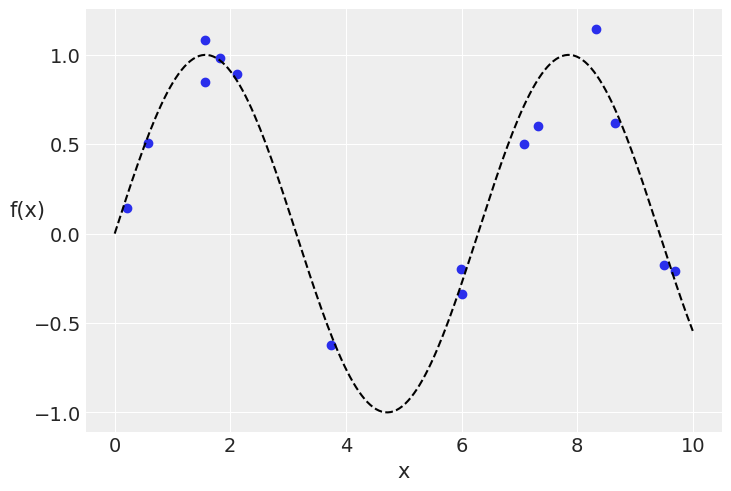

In [43]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0)

In [44]:
# A one dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instanciate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instanciate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    ϵ = pm.HalfNormal('ϵ', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)
    trace_reg = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, ℓ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.


In [45]:
%config InlineBackend.figure_format = 'retina'


/home/hona/anaconda3/envs/py38/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'ℓ'}>,
        <AxesSubplot:title={'center':'ℓ'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

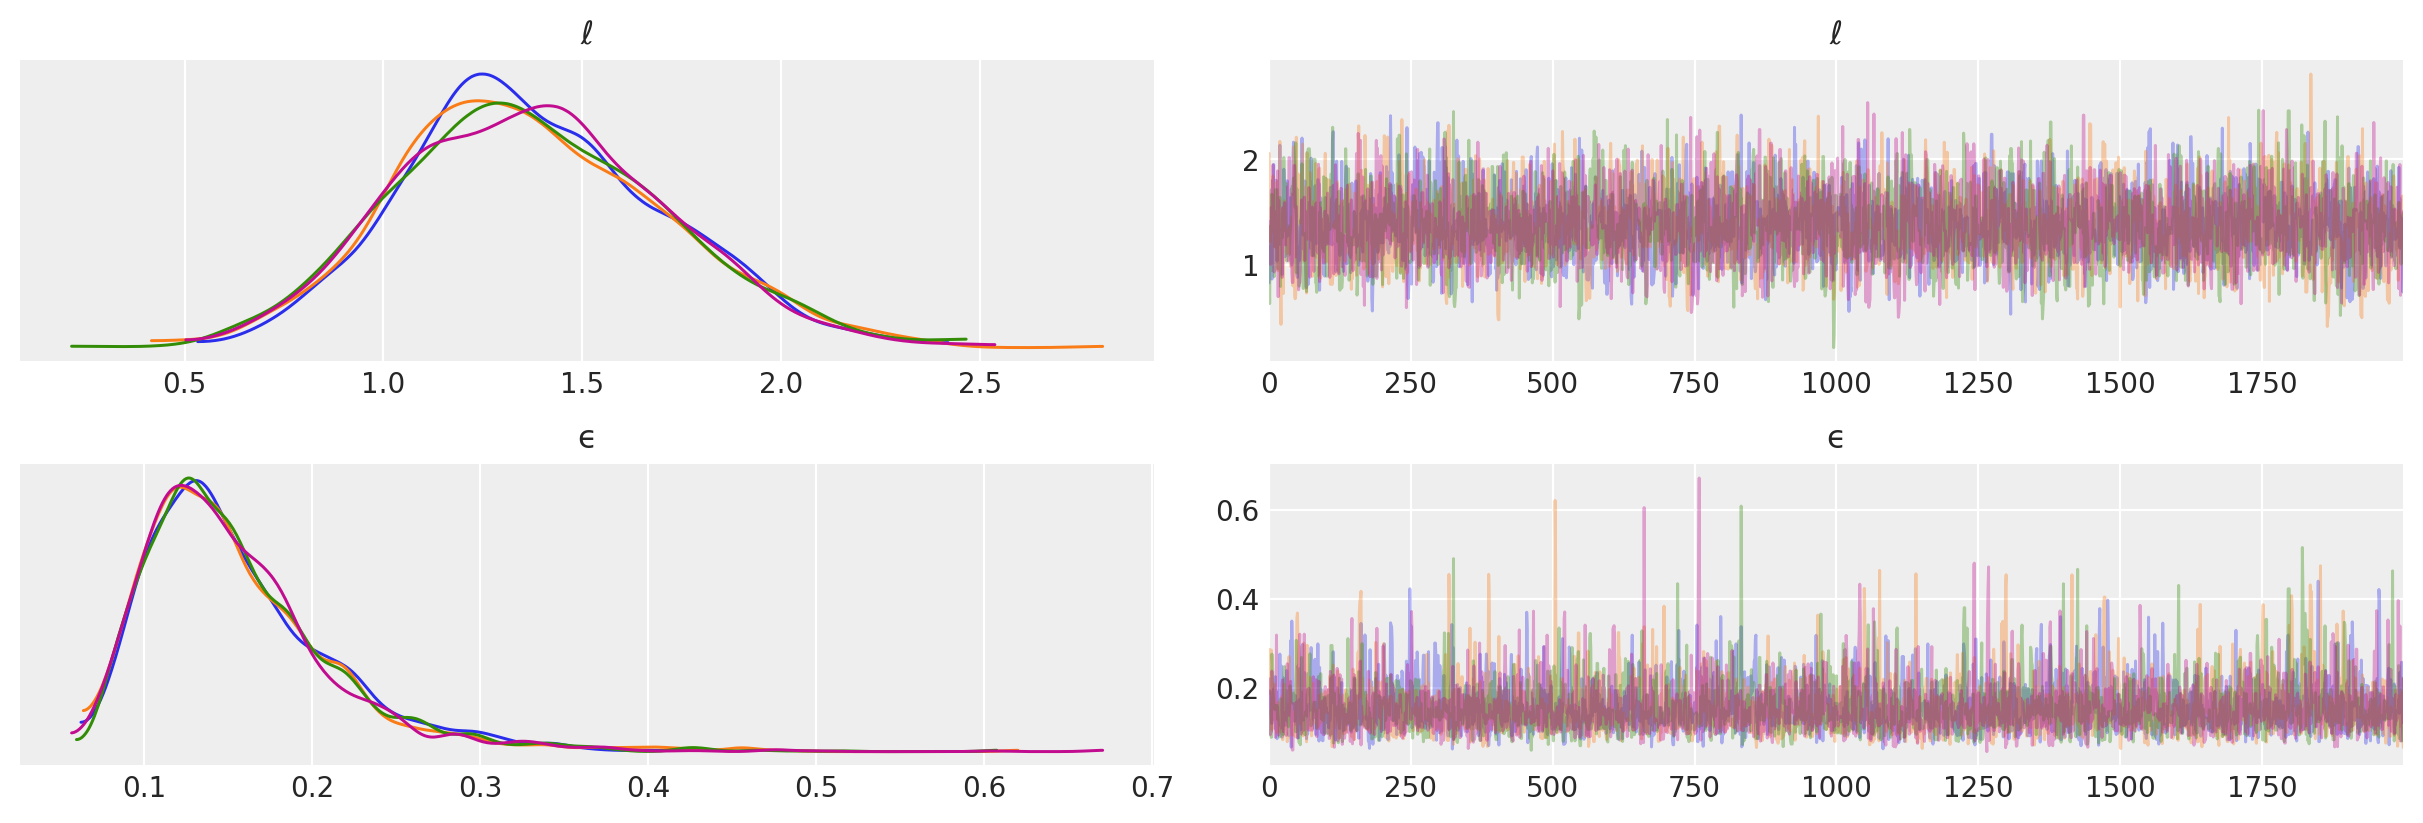

In [46]:
az.plot_trace(trace_reg)


In [47]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]

with model_reg:
    #del marginal_gp_model.named_vars['f_pred']
    #marginal_gp_model.vars.remove(f_pred)
    f_pred = gp.conditional('f_pred', X_new)

In [48]:
with model_reg:
    pred_samples = pm.sample_posterior_predictive(trace_reg, vars=[f_pred], samples=82)

/home/hona/anaconda3/envs/py38/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Text(0.5, 0, 'X')

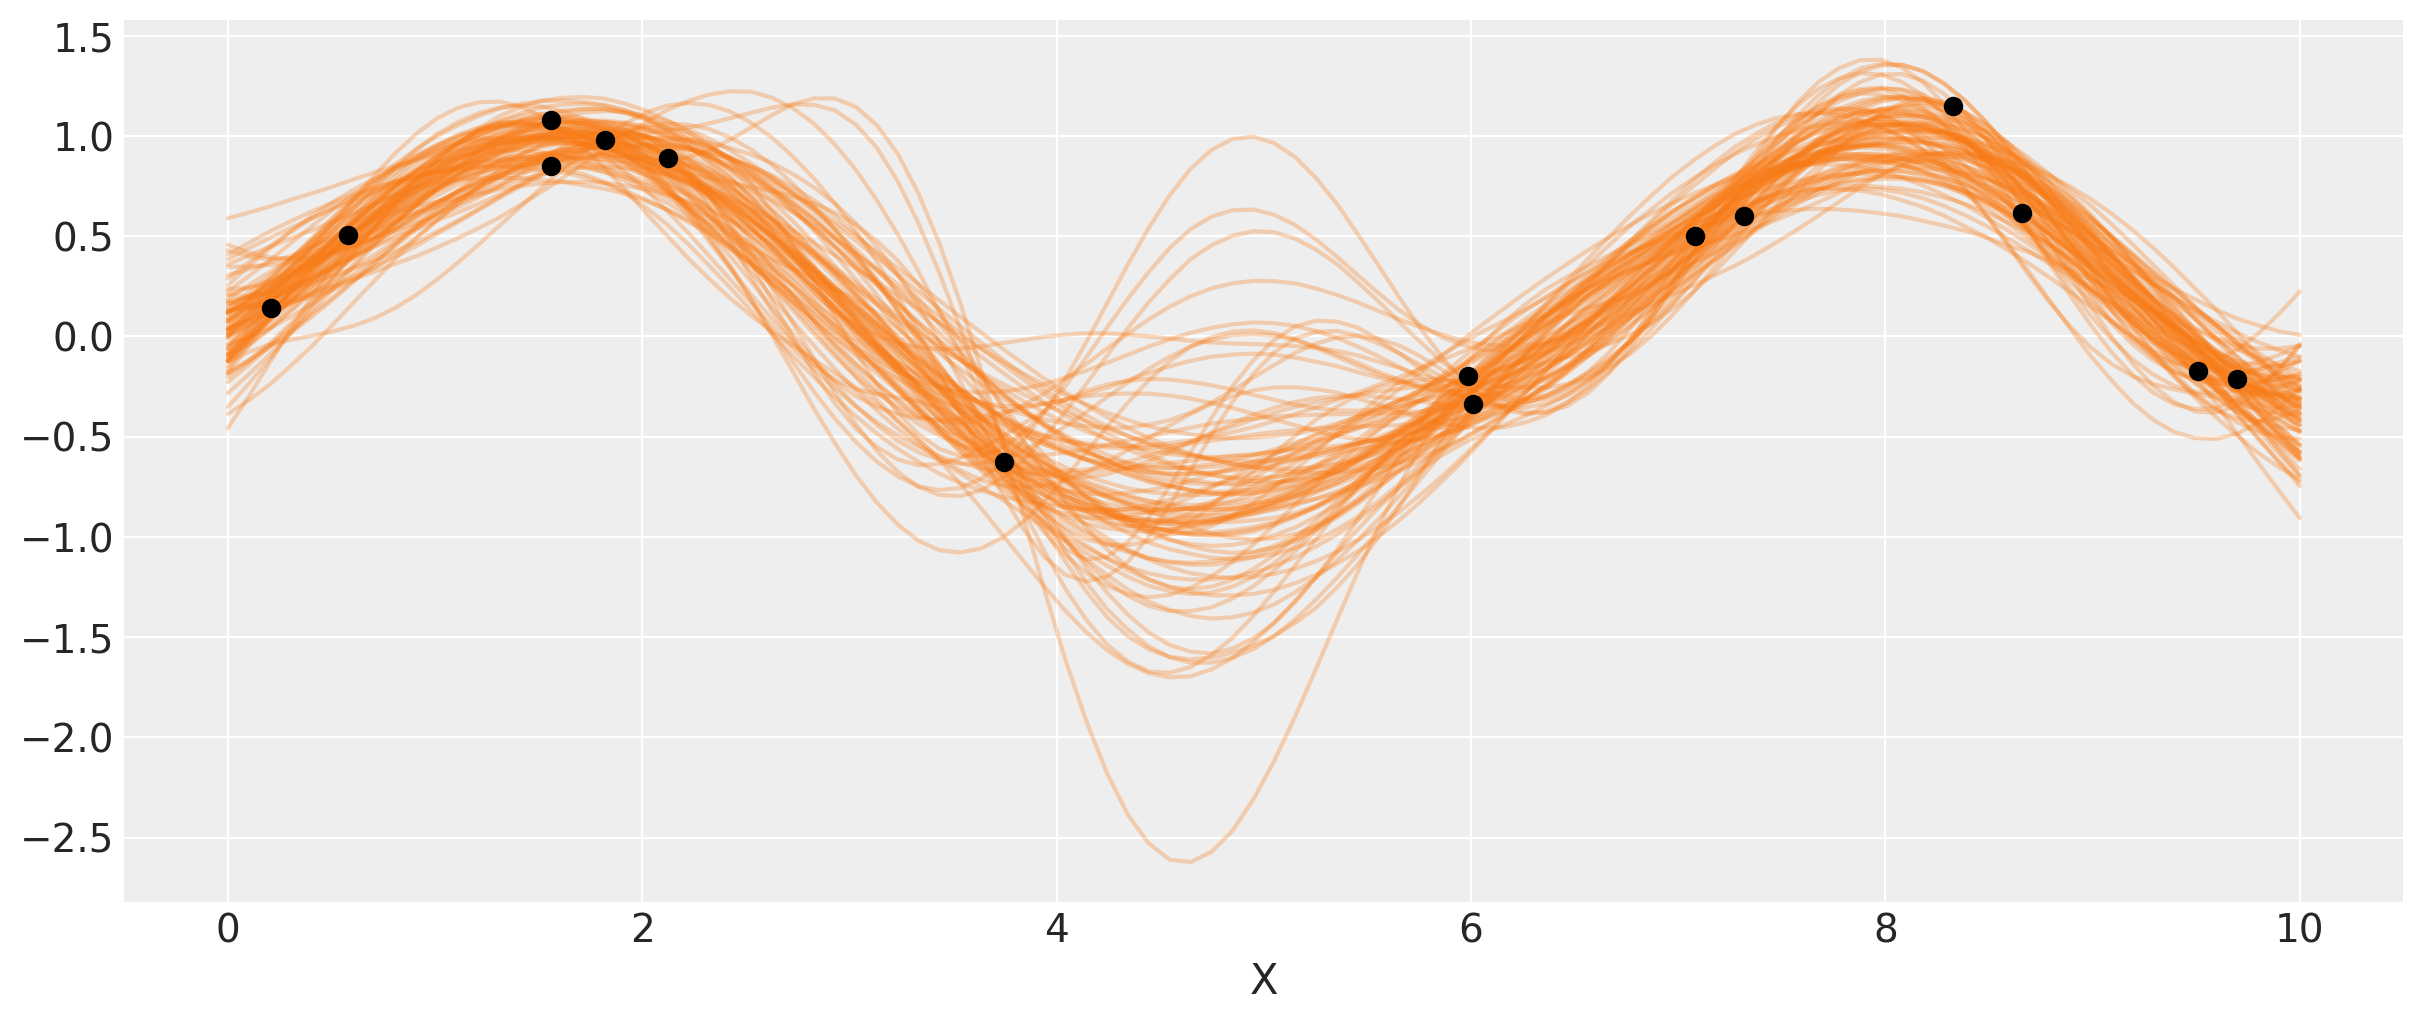

In [49]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')

Text(0, 0.5, 'f(x)')

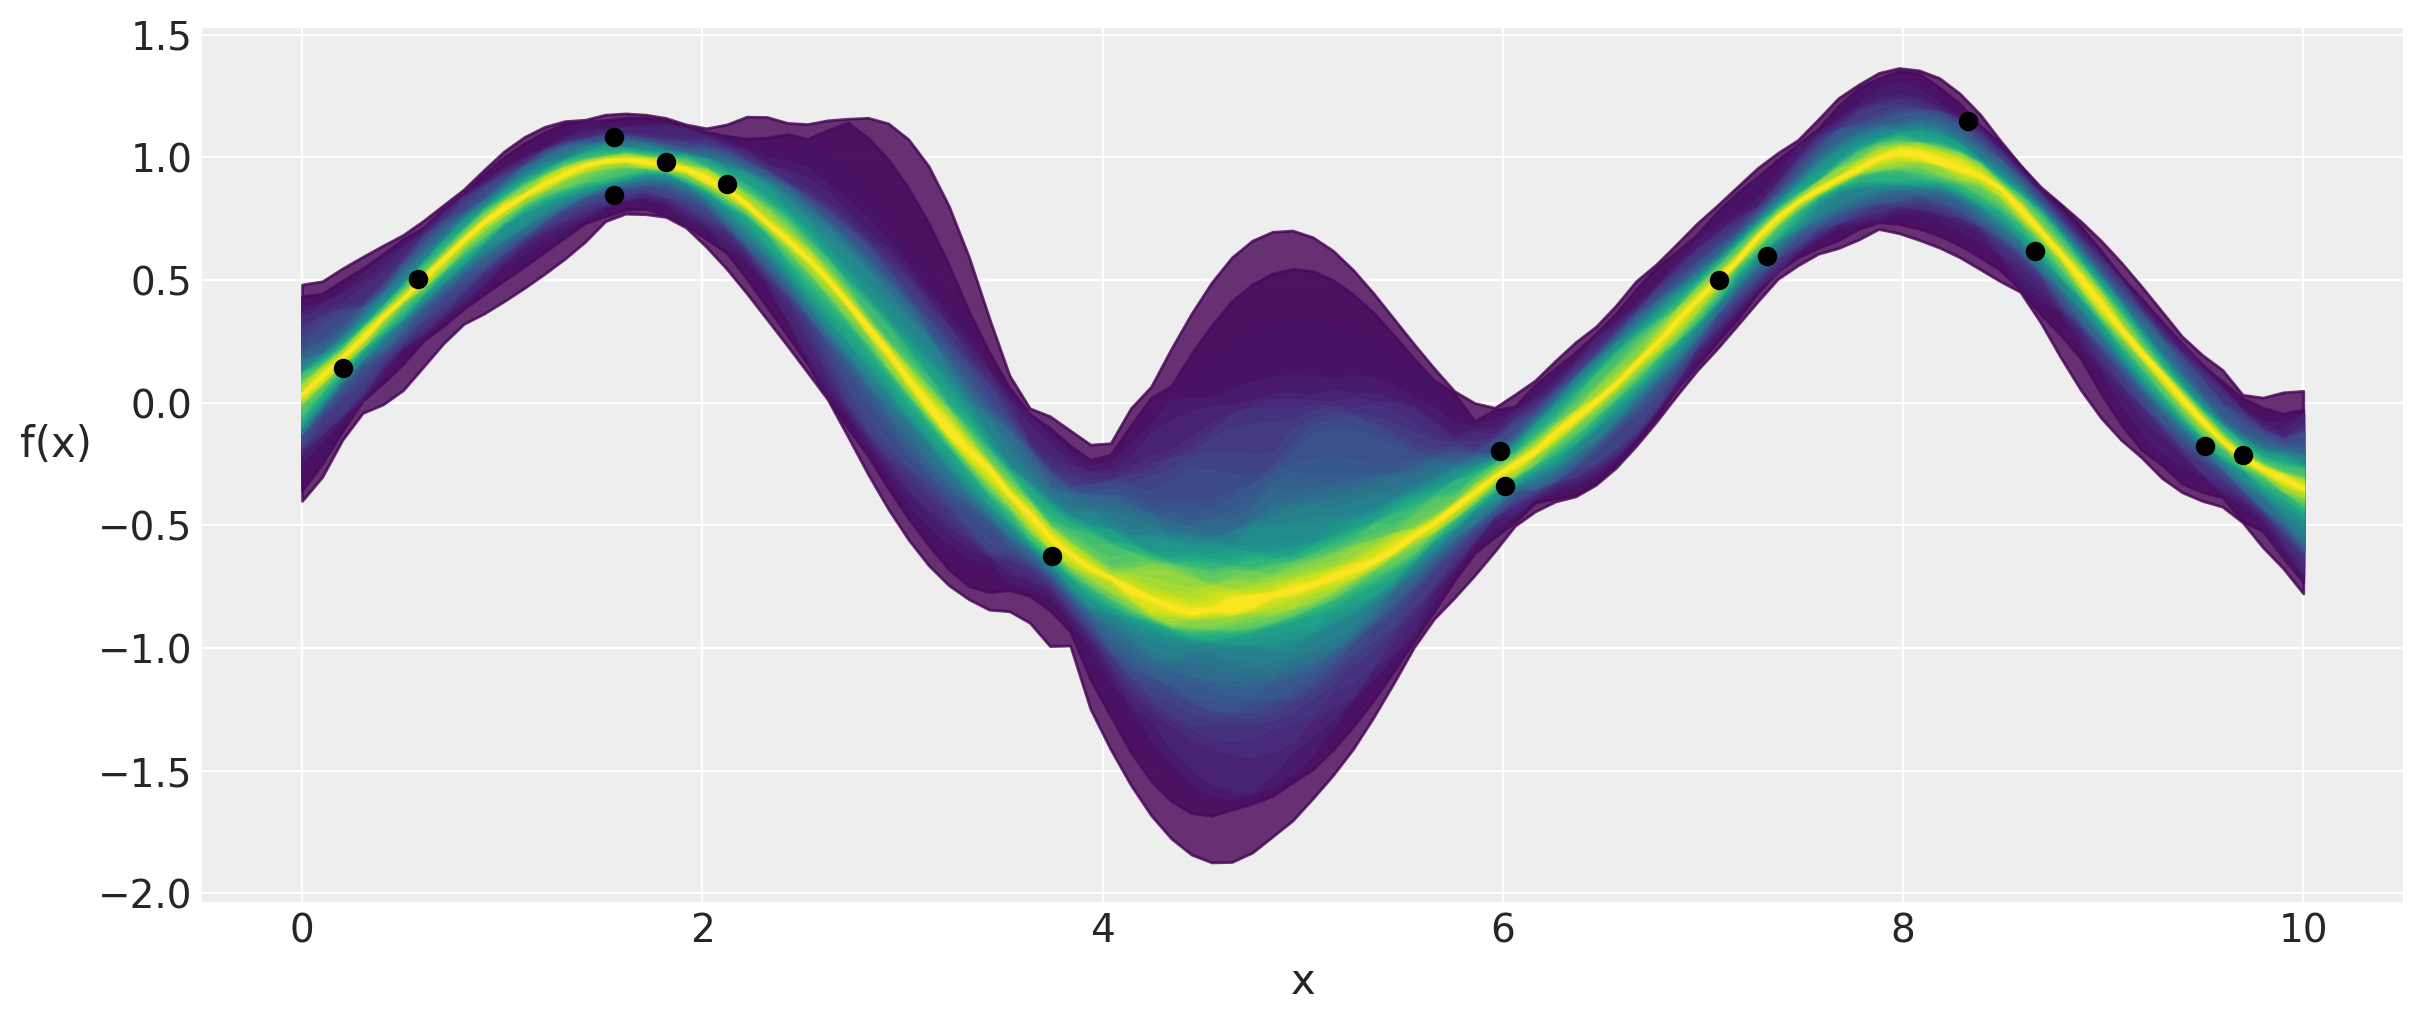

In [50]:
_, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred'], X_new, palette='viridis', plot_samples=False);

ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)

Text(0.5, 0, 'X')

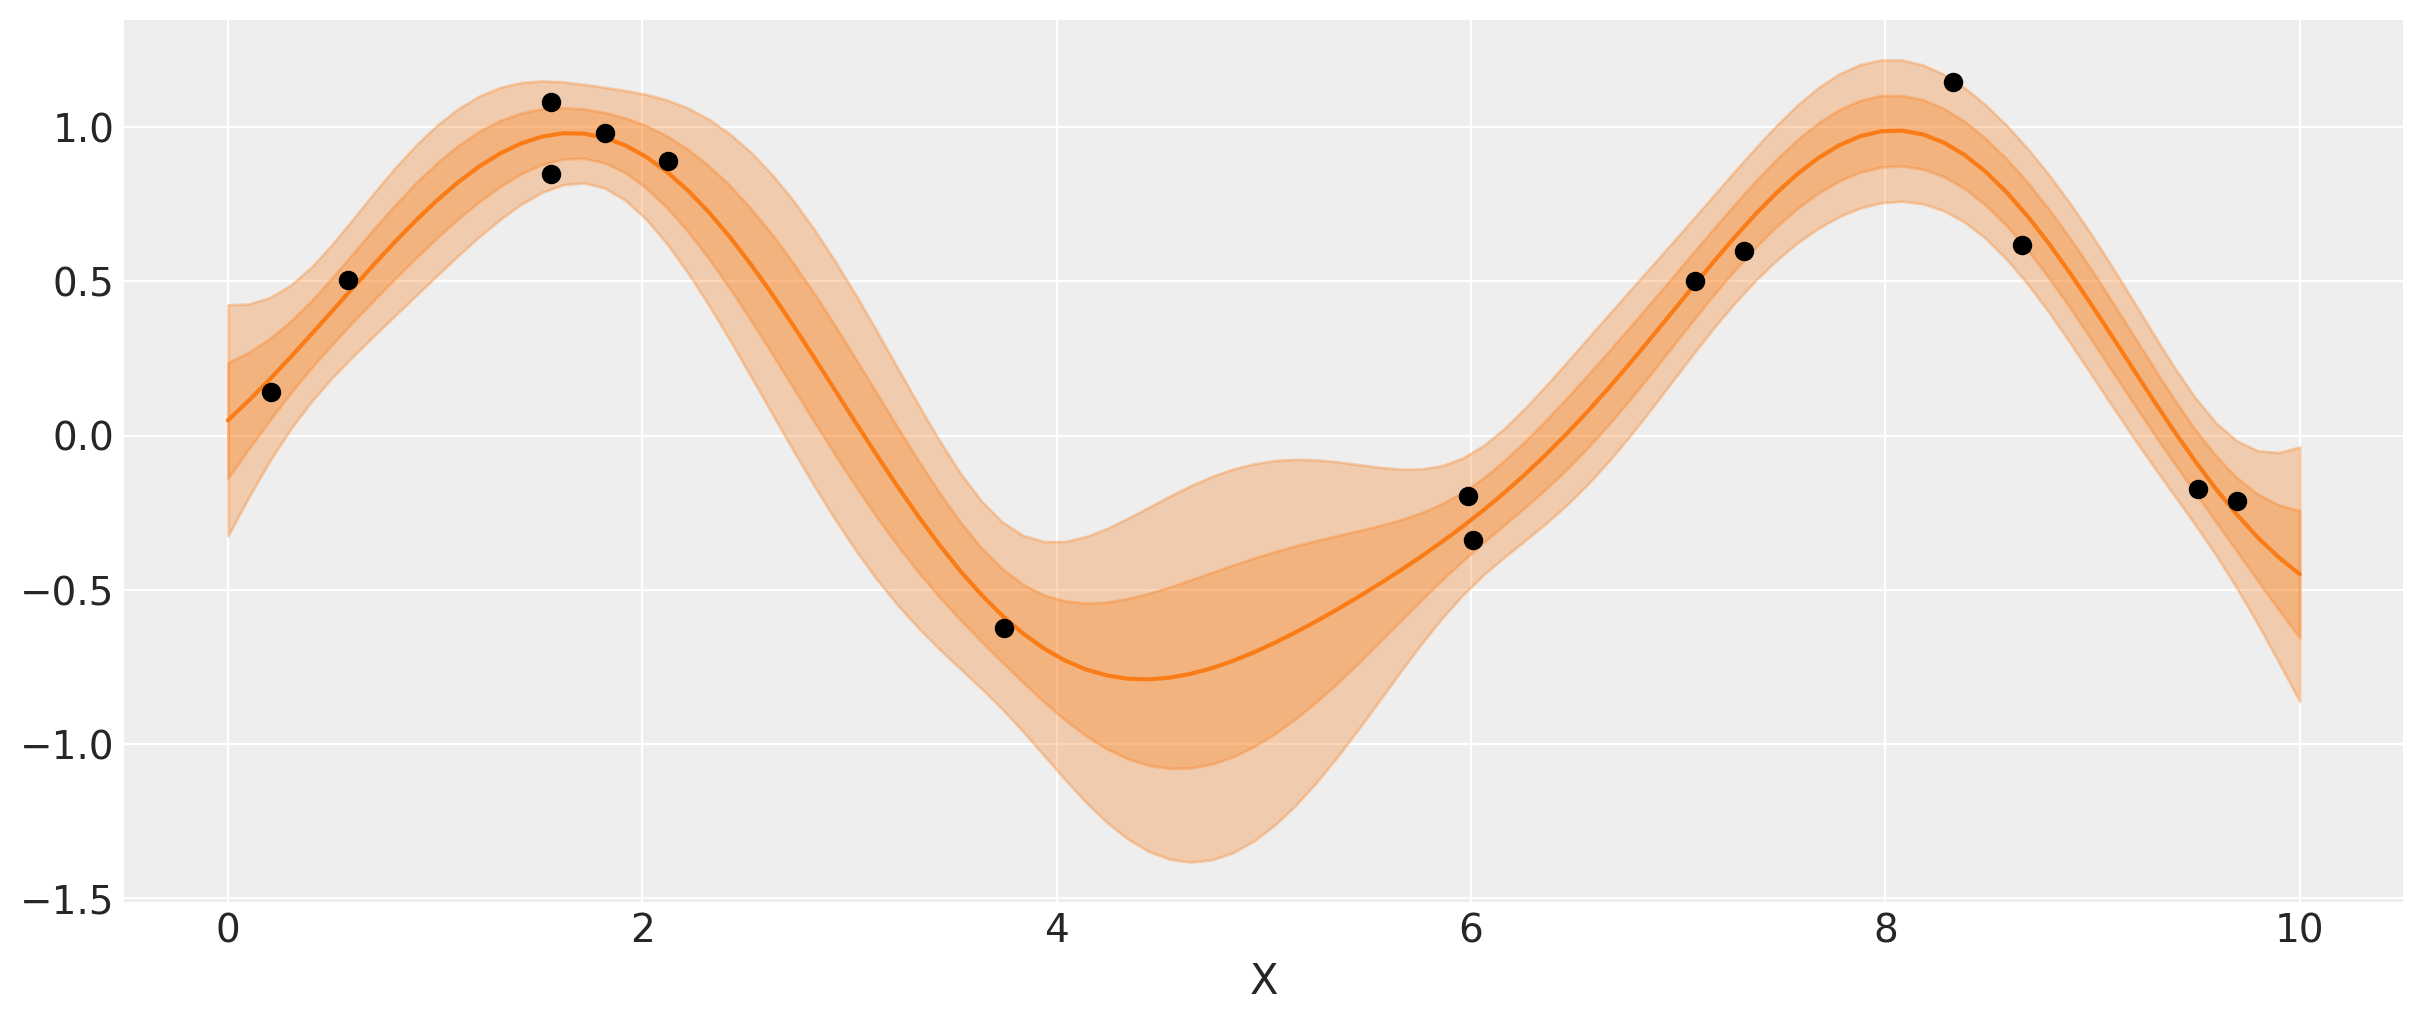

In [51]:
# plot the results
_, ax = plt.subplots(figsize=(12,5))

# predict
point = {'ℓ': trace_reg['ℓ'].mean(), 'ϵ': trace_reg['ϵ'].mean()}
mu, var = gp.predict(X_new, point=point, diag=True)
sd = var**0.5

# plot mean and 1σ and 2σ intervals
ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)

ax.fill_between(X_new.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X')

#### Regression with spatial autocorrelation¶

In [52]:
islands_dist = pd.read_csv('./data/islands_dist.csv',
                           sep=',', index_col=0)
islands_dist.round(1)

Ml   Ti   SC   Ya   Fi   Tr   Ch   Mn   To   Ha
Malekula    0.0  0.5  0.6  4.4  1.2  2.0  3.2  2.8  1.9  5.7
Tikopia     0.5  0.0  0.3  4.2  1.2  2.0  2.9  2.7  2.0  5.3
Santa Cruz  0.6  0.3  0.0  3.9  1.6  1.7  2.6  2.4  2.3  5.4
Yap         4.4  4.2  3.9  0.0  5.4  2.5  1.6  1.6  6.1  7.2
Lau Fiji    1.2  1.2  1.6  5.4  0.0  3.2  4.0  3.9  0.8  4.9
Trobriand   2.0  2.0  1.7  2.5  3.2  0.0  1.8  0.8  3.9  6.7
Chuuk       3.2  2.9  2.6  1.6  4.0  1.8  0.0  1.2  4.8  5.8
Manus       2.8  2.7  2.4  1.6  3.9  0.8  1.2  0.0  4.6  6.7
Tonga       1.9  2.0  2.3  6.1  0.8  3.9  4.8  4.6  0.0  5.0
Hawaii      5.7  5.3  5.4  7.2  4.9  6.7  5.8  6.7  5.0  0.0

In [53]:
islands = pd.read_csv('./data/islands.csv', sep=',')
islands.head().round(1)

culture  population contact  total_tools  mean_TU   lat    lon  lon2  \
0    Malekula        1100     low           13      3.2 -16.3  167.5 -12.5   
1     Tikopia        1500     low           22      4.7 -12.3  168.8 -11.2   
2  Santa Cruz        3600     low           24      4.0 -10.7  166.0 -14.0   
3         Yap        4791    high           43      5.0   9.5  138.1 -41.9   
4    Lau Fiji        7400    high           33      5.0 -17.7  178.1  -1.9   

   logpop  
0     7.0  
1     7.3  
2     8.2  
3     8.5  
4     8.9

In [54]:
islands_dist_sqr = islands_dist.values**2
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

In [55]:
with pm.Model() as model_islands:
    η = pm.HalfCauchy('η', 1)
    ℓ = pm.HalfCauchy('ℓ', 1)
    
    cov = η * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=islands_dist_sqr)

    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + f[index] + β * log_pop)
    tt_pred = pm.Poisson('tt_pred', μ, observed=total_tools)
    trace_islands = pm.sample(1000, tune=1000)

/home/hona/anaconda3/envs/py38/lib/python3.8/site-packages/pymc3/gp/cov.py:90: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(f"Only {self.input_dim} column(s) out of {X.shape[-1]} are"
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α, f_rotated_, ℓ, η]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 216 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Text(0, 0.5, 'covariance')

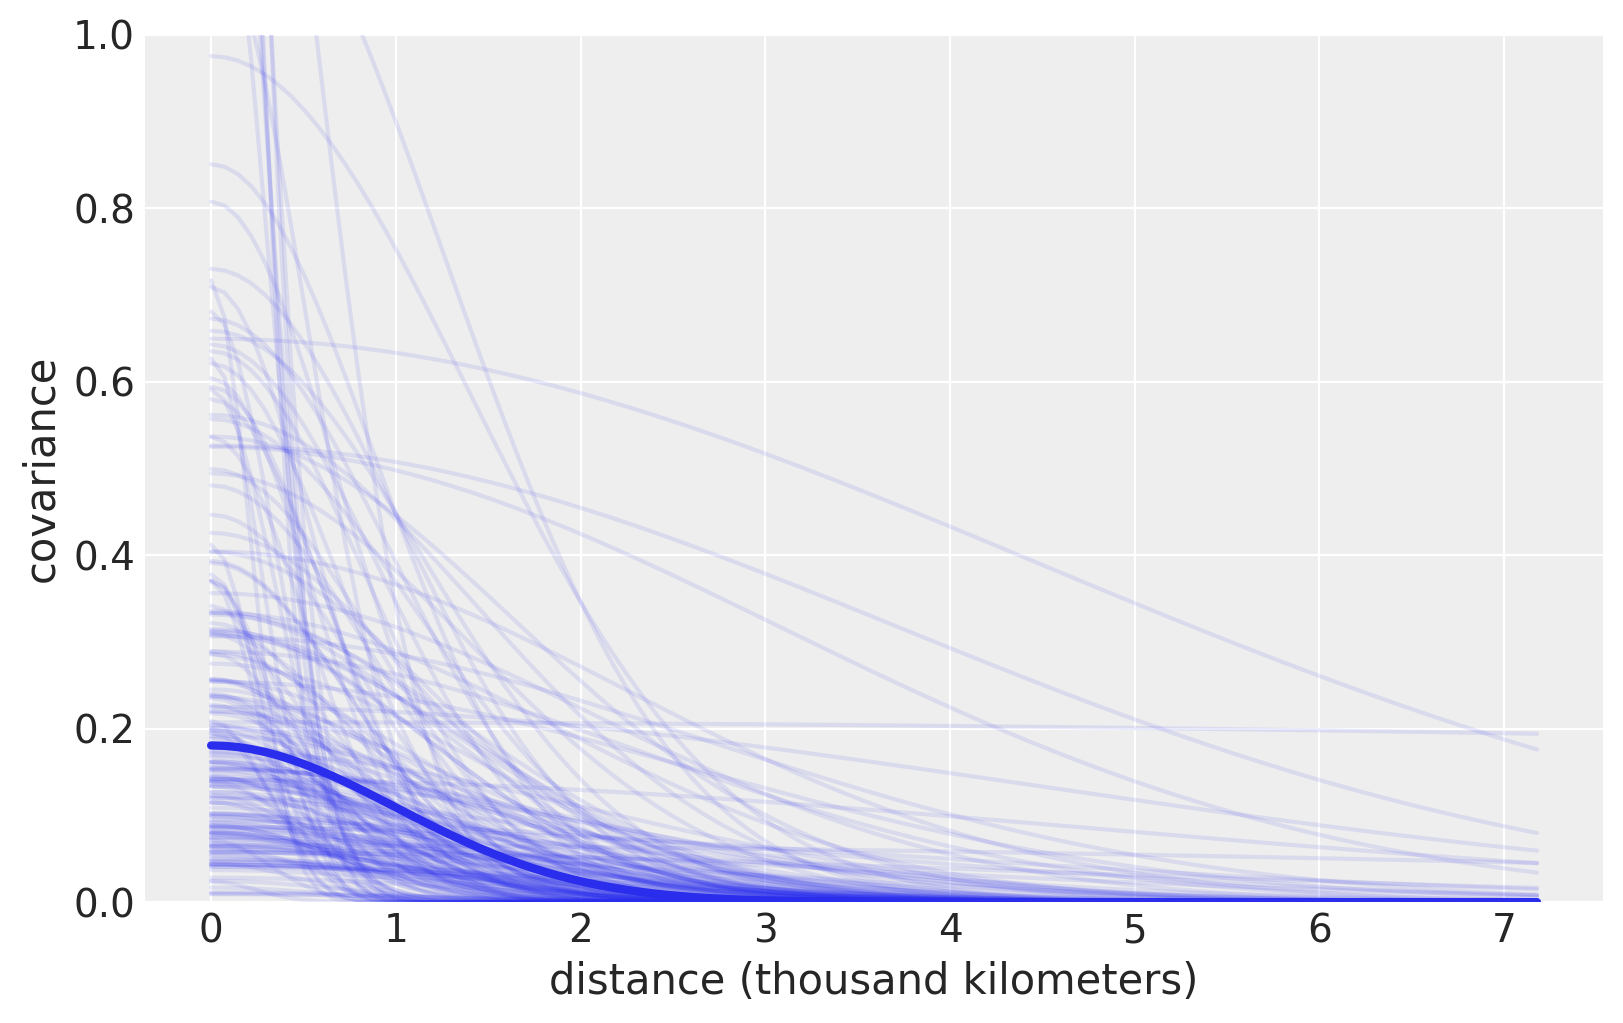

In [57]:
trace_η = trace_islands['η']
trace_ℓ = trace_islands['ℓ']

_, ax = plt.subplots(1, 1, figsize=(8, 5))
xrange = np.linspace(0, islands_dist.values.max(), 100)

ax.plot(xrange, np.median(trace_η) *
        np.exp(-np.median(trace_ℓ) * xrange**2), lw=3)

ax.plot(xrange, (trace_η[::20][:, None] * np.exp(- trace_ℓ[::20][:, None] * xrange**2)).T,
        'C0', alpha=.1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance')

In [58]:
# compute posterior median covariance among societies
Σ = np.median(trace_η) * (np.exp(-np.median(trace_ℓ) * islands_dist_sqr))
# convert to correlation matrix
Σ_post = np.diag(np.diag(Σ)**-0.5)
ρ = Σ_post @  Σ @ Σ_post
ρ = pd.DataFrame(ρ, index=islands_dist.columns, columns=islands_dist.columns)
ρ.round(2)

Ml    Ti    SC    Ya    Fi    Tr    Ch    Mn    To   Ha
Ml  1.00  0.89  0.82  0.00  0.46  0.12  0.01  0.02  0.18  0.0
Ti  0.89  1.00  0.95  0.00  0.46  0.13  0.02  0.03  0.14  0.0
SC  0.82  0.95  1.00  0.00  0.30  0.23  0.03  0.06  0.07  0.0
Ya  0.00  0.00  0.00  1.00  0.00  0.05  0.30  0.27  0.00  0.0
Fi  0.46  0.46  0.30  0.00  1.00  0.01  0.00  0.00  0.75  0.0
Tr  0.12  0.13  0.23  0.05  0.01  1.00  0.20  0.70  0.00  0.0
Ch  0.01  0.02  0.03  0.30  0.00  0.20  1.00  0.48  0.00  0.0
Mn  0.02  0.03  0.06  0.27  0.00  0.70  0.48  1.00  0.00  0.0
To  0.18  0.14  0.07  0.00  0.75  0.00  0.00  0.00  1.00  0.0
Ha  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.0

/home/hona/anaconda3/envs/py38/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


(10.0, 73.0)

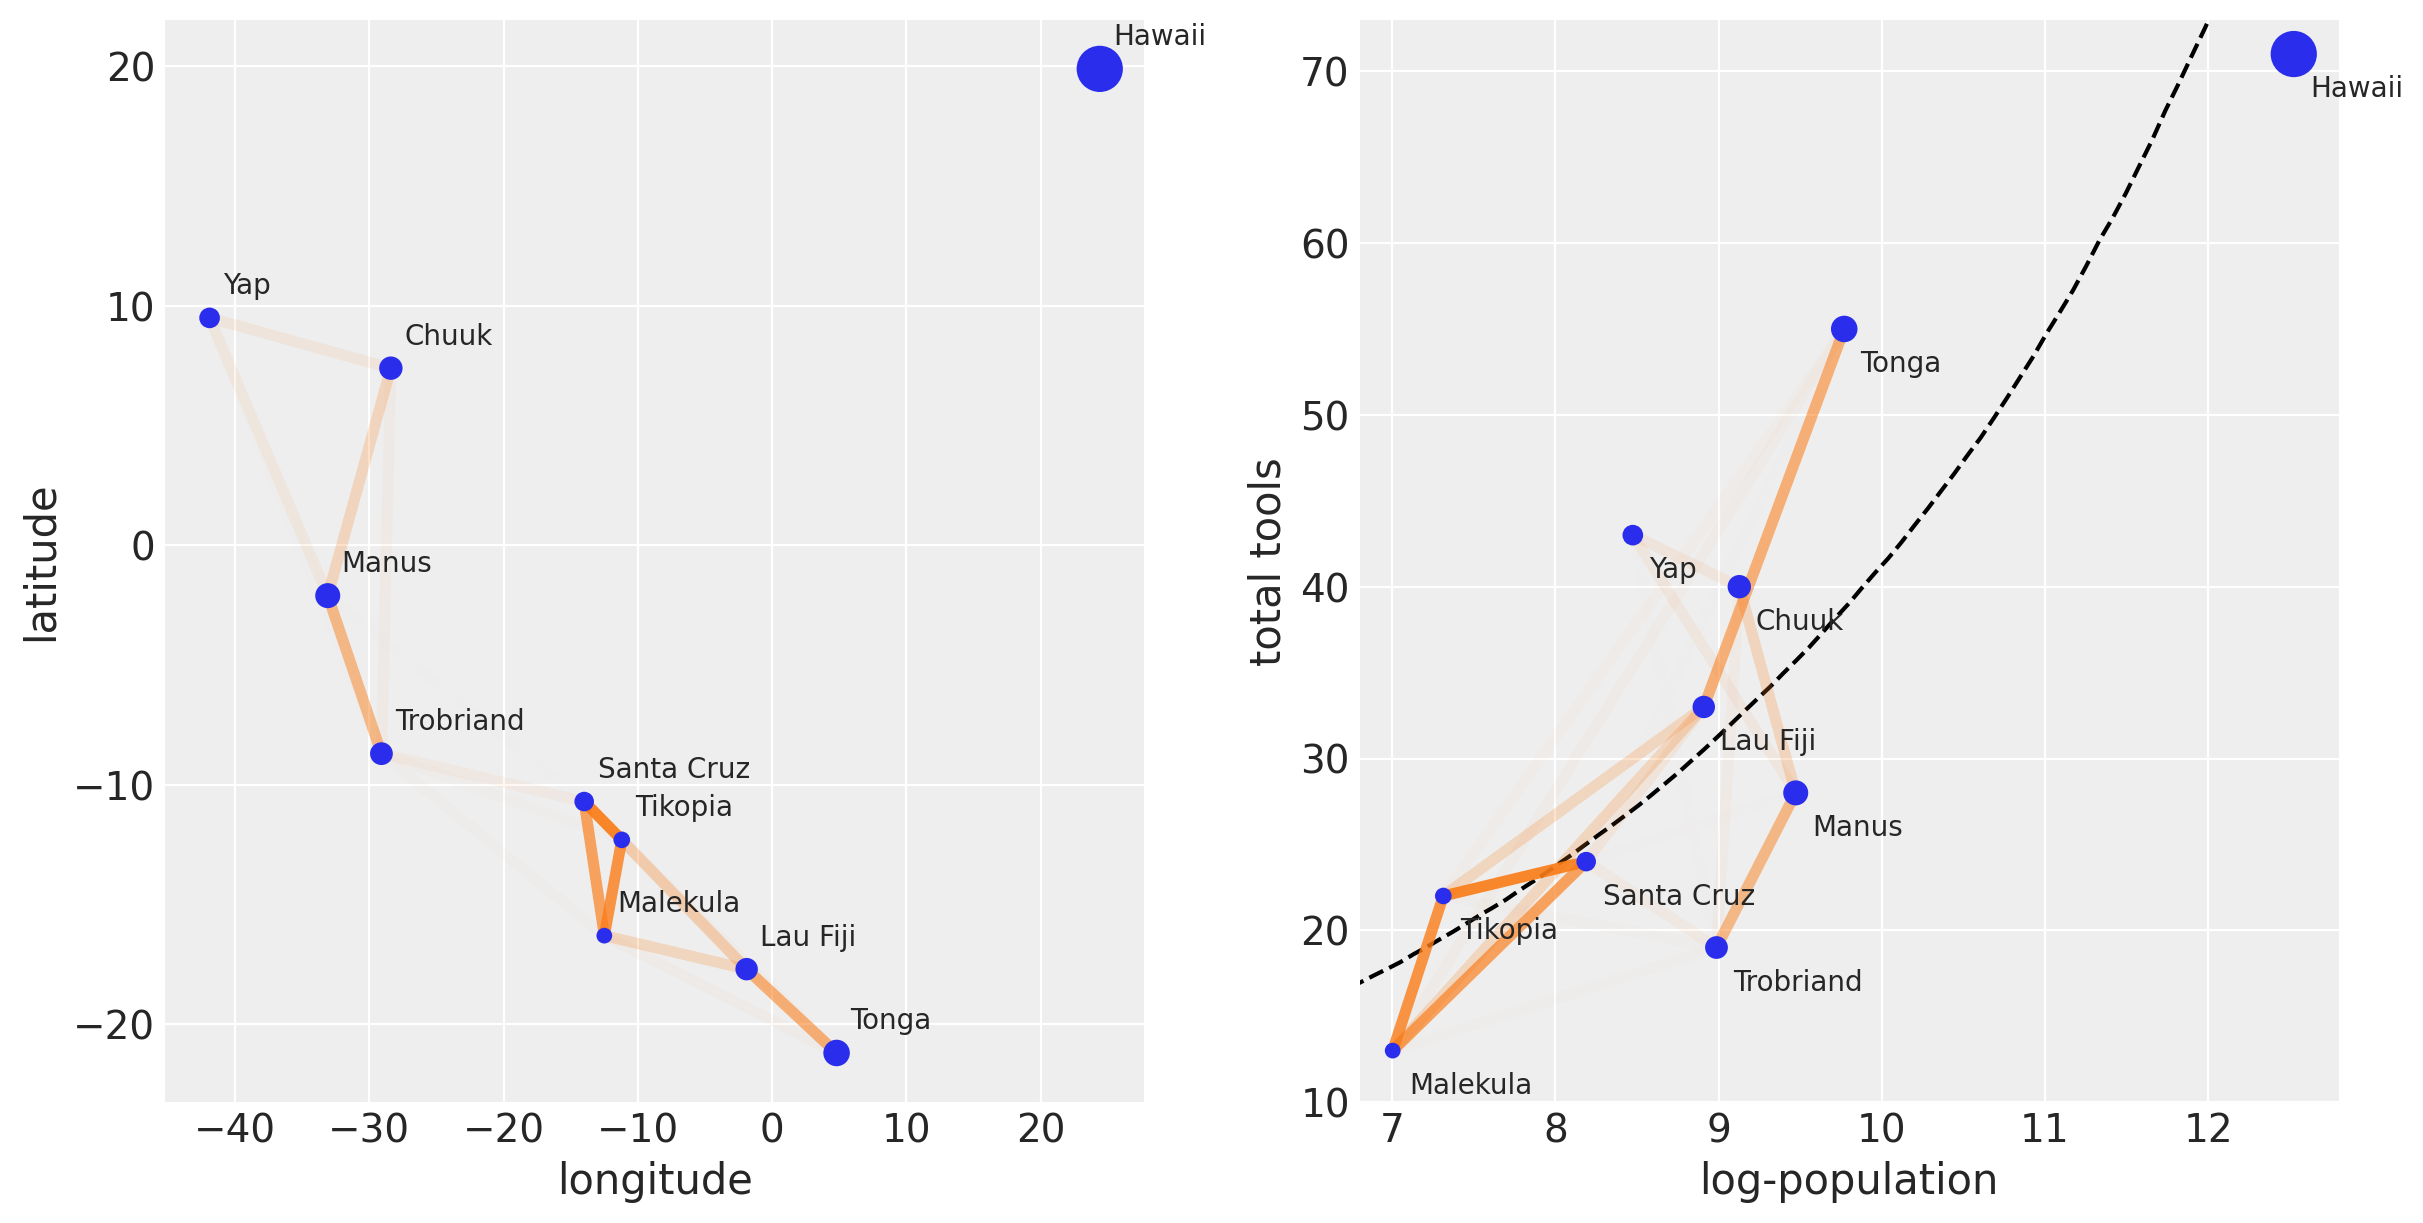

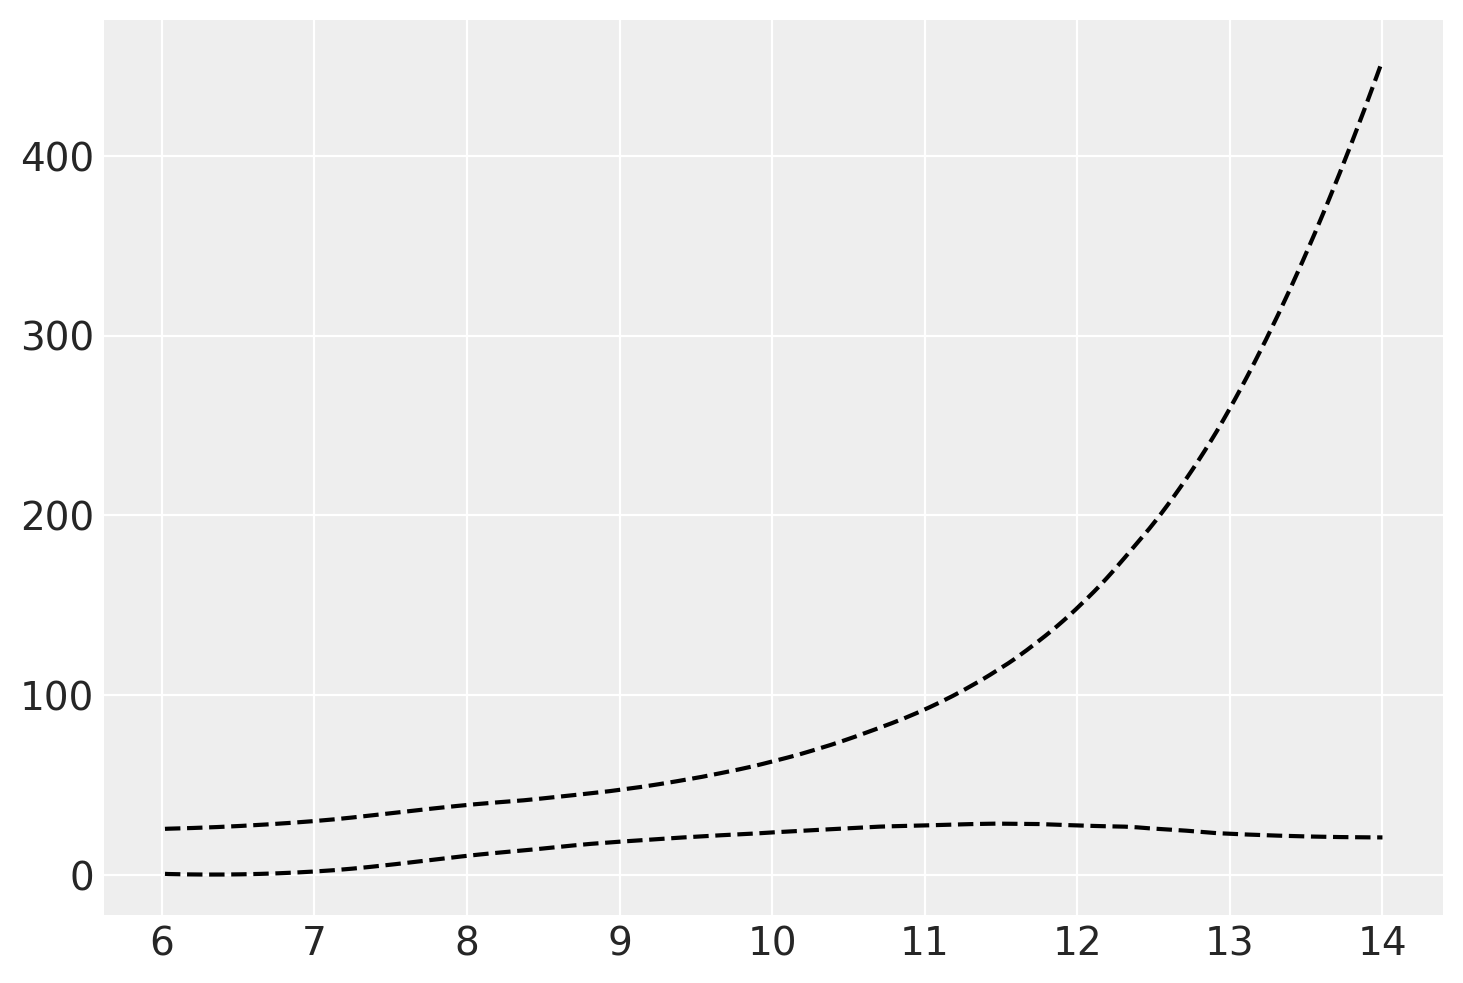

In [60]:
# scale point size to logpop
logpop = np.copy(log_pop)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(trace_islands['α'][:, None] +
                     trace_islands['β'][:, None] * log_pop_seq)

_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(islands.lon2, islands.lat, psize, zorder=3)
ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder=3)

for i, itext in enumerate(culture_labels):
    ax[0].text(islands.lon2[i]+1, islands.lat[i]+1, itext)
    ax[1].text(islands.logpop[i]+.1, islands.total_tools[i]-2.5, itext)


ax[1].plot(log_pop_seq, np.median(lambda_post, axis=0), 'k--')

az.plot_hpd(log_pop_seq, lambda_post, fill_kwargs={'alpha':0},
            plot_kwargs={'color':'k', 'ls':'--', 'alpha':1})


for i in range(10):
    for j in np.arange(i+1, 10):
        ax[0].plot((islands.lon2[i], islands.lon2[j]),
                   (islands.lat[i], islands.lat[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
        ax[1].plot((islands.logpop[i], islands.logpop[j]),
                   (islands.total_tools[i], islands.total_tools[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')


ax[1].set_xlabel('log-population')
ax[1].set_ylabel('total tools')
ax[1].set_xlim(6.8, 12.8)
ax[1].set_ylim(10, 73)
#plt.savefig('B11197_07_10.png')

#### the redwood data


Text(0, 0.5, 'x2 coordinate')

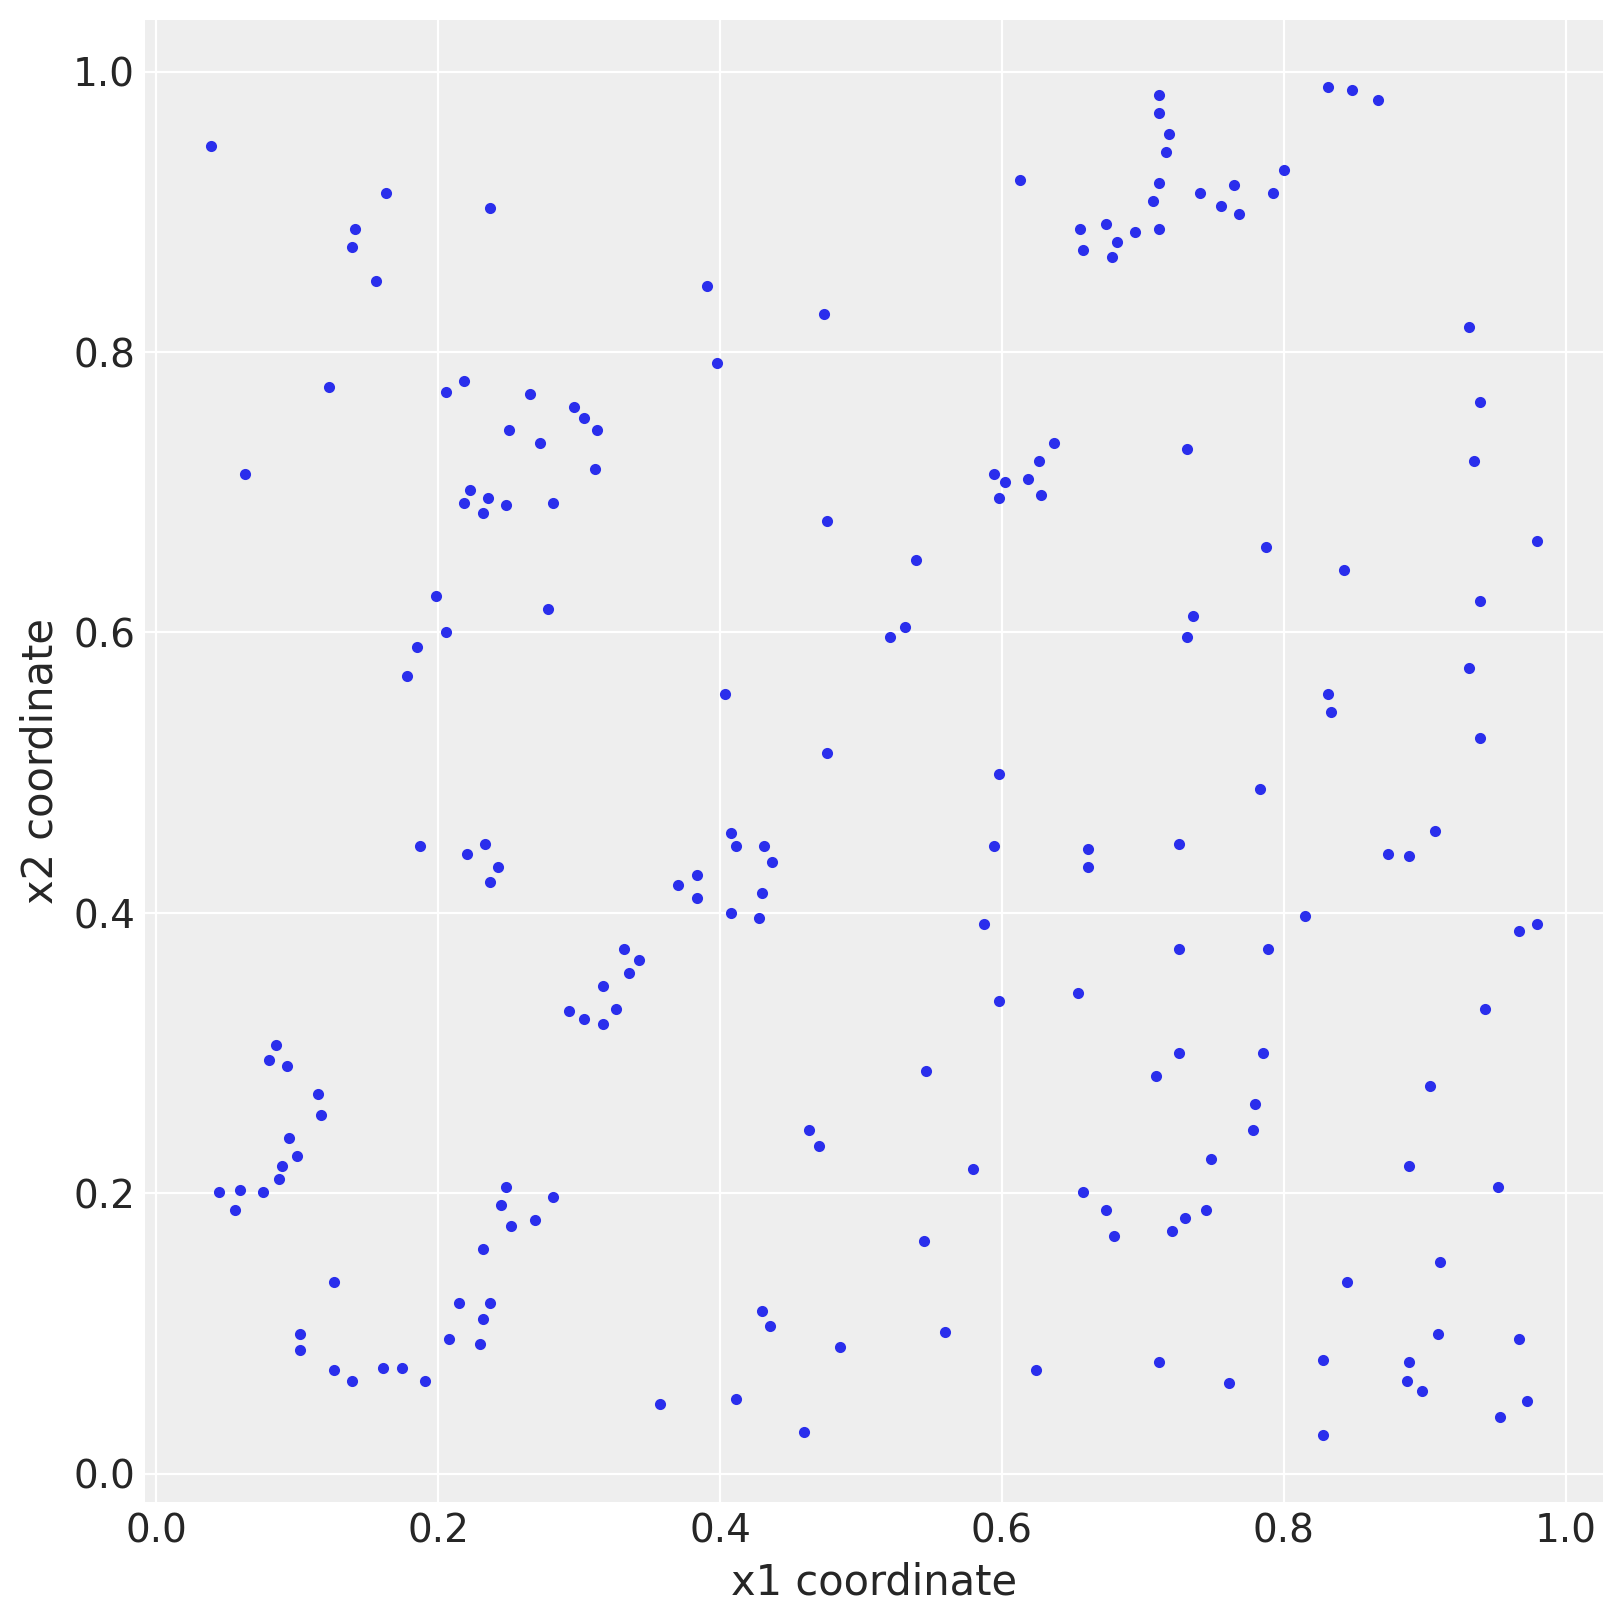

In [61]:
rw_df = pd.read_csv('./data/redwood.csv', header=None)
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(rw_df[0], rw_df[1], 'C0.')
ax.set_xlabel('x1 coordinate')
ax.set_ylabel('x2 coordinate')
#plt.savefig('B11197_07_16.png')

In [62]:
# discretize spatial data
bins = 20
hist, x1_edges, x2_edges = np.histogram2d(
    rw_df[1].values, rw_df[0].values, bins=bins)
# compute the location of the centers of the discretized data
x1_centers = x1_edges[:-1] + (x1_edges[1] - x1_edges[0]) / 2
x2_centers = x2_edges[:-1] + (x2_edges[1] - x2_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = [x1_centers[:, None], x2_centers[:, None]]
# arrange ydata into proper shape for GP
y_data = hist.flatten()

In [63]:
with pm.Model() as model_rw:
    ℓ = pm.HalfNormal('ℓ',  rw_df.std().values, shape=2)
    cov_func1 = pm.gp.cov.ExpQuad(1, ls=ℓ[0])
    cov_func2 = pm.gp.cov.ExpQuad(1, ls=ℓ[1])

    gp = pm.gp.LatentKron(cov_funcs=[cov_func1, cov_func2])
    f = gp.prior('f', Xs=x_data)

    y = pm.Poisson('y', mu=pm.math.exp(f), observed=y_data)
    trace_rw = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, ℓ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 211 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [64]:
az.summary(trace_rw, var_names=['ℓ'])

/home/hona/anaconda3/envs/py38/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
ℓ[0]  0.125  0.033   0.077    0.177      0.002    0.001     397.0   397.0   
ℓ[1]  0.094  0.026   0.055    0.141      0.002    0.001     269.0   269.0   

      ess_bulk  ess_tail  r_hat  
ℓ[0]     454.0     536.0   1.00  
ℓ[1]     271.0     585.0   1.03

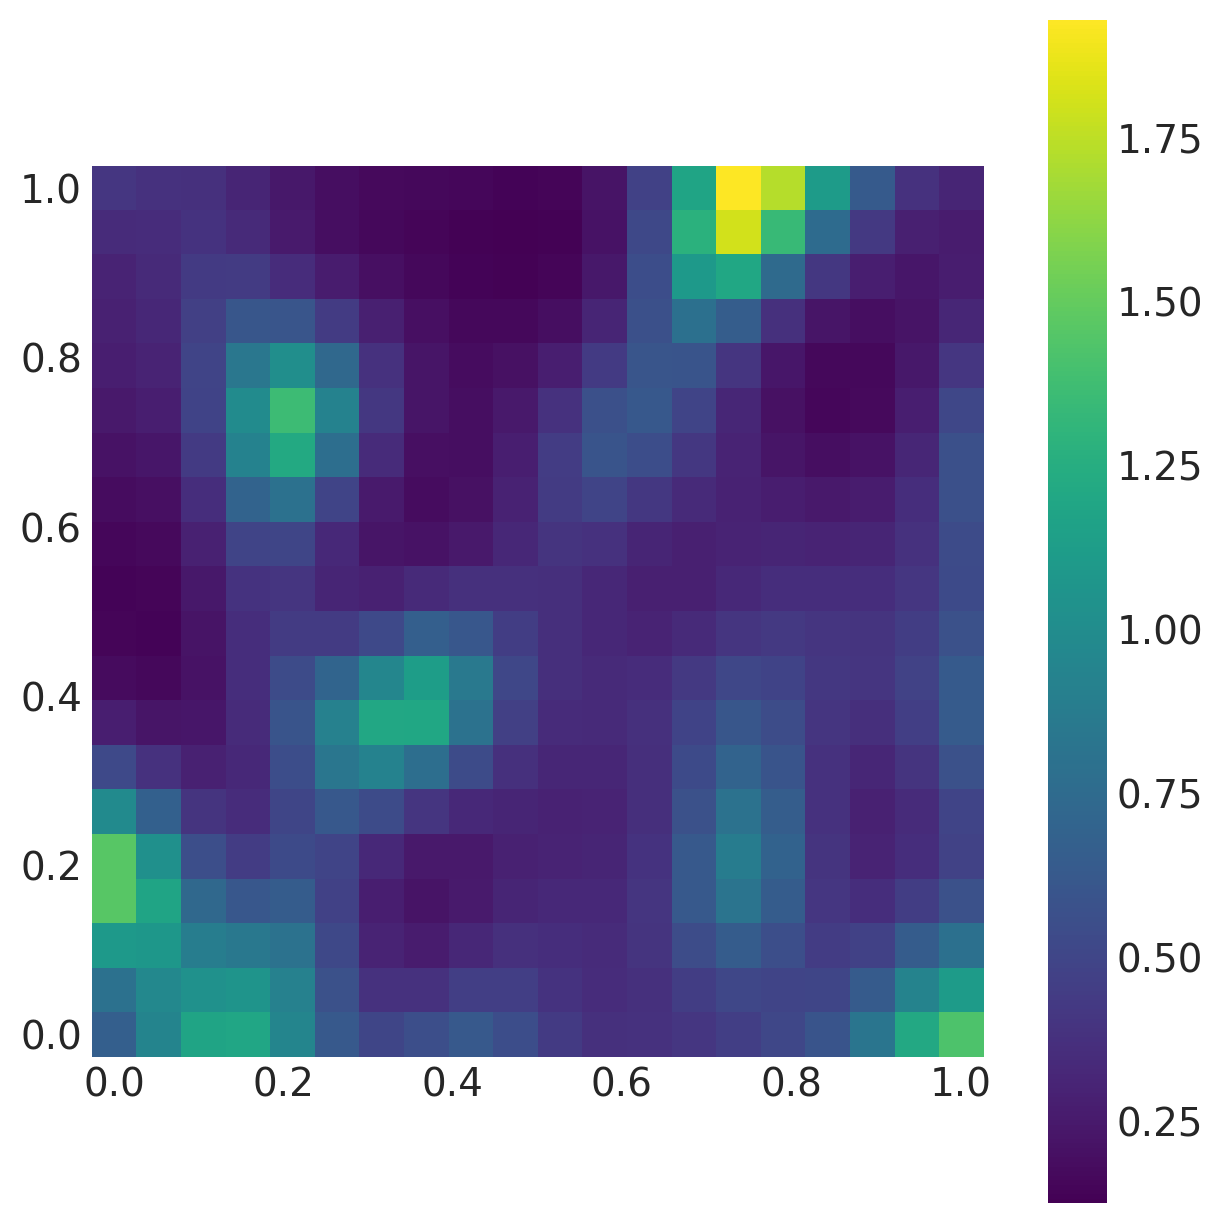

In [65]:
rate = np.exp(np.mean(trace_rw['f'], axis=0).reshape((bins, -1)))
fig, ax = plt.subplots(figsize=(6, 6))
ims = ax.imshow(rate, origin='lower')
ax.grid(False)
ticks_loc = np.linspace(0, bins-1, 6)
ticks_lab = np.linspace(0, 1, 6).round(1)
ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(ticks_lab)
ax.set_yticklabels(ticks_lab)
cbar = fig.colorbar(ims, fraction=0.046, pad=0.04)